Found classes: ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

--- Image Counts ---
Class 'Potato___Early_blight': 1000 images
Class 'Potato___healthy': 152 images
Class 'Potato___Late_blight': 1000 images


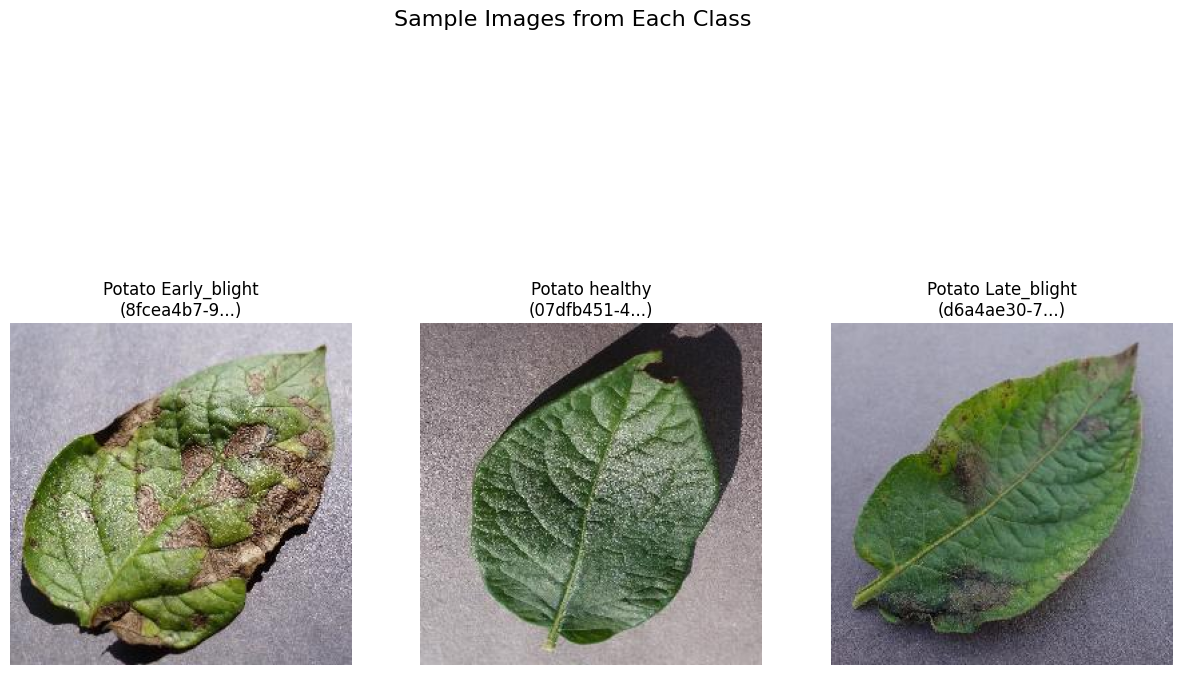

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define the path to our data directory
data_dir = '../data/'

# Get the class names (the subdirectories)
class_names = os.listdir(data_dir)
print(f"Found classes: {class_names}")

print("\n--- Image Counts ---")
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    # Filter out non-directory files like .DS_Store
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"Class '{class_name}': {num_images} images")

# --- Visualize a few random images from each class ---
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Get a list of all image file names in the class directory
        image_files = os.listdir(class_path)
        
        # Select one random image from the list
        random_image_name = random.choice(image_files)
        random_image_path = os.path.join(class_path, random_image_name)
        
        # Load the image
        img = mpimg.imread(random_image_path)
        
        # Create a subplot and display the image
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(f"{class_name.replace('___', ' ')}\n({random_image_name[:10]}...)")
        plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()

In [8]:
import tensorflow as tf

# --- Define constants ---
IMG_SIZE = (224, 224) # The image size our model will expect
BATCH_SIZE = 32      # Process images in batches of 32

# --- Create the datasets ---
# Use a built-in Keras utility to load the images from the directory
# It will automatically split the data for us.
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # 20% of data for validation
    subset="training",      # This is the training set
    seed=123,               # Seed for reproducibility
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # 20% of data for validation
    subset="validation",    # This is the validation set
    seed=123,               # Seed for reproducibility
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- Print information about the datasets ---
class_names = train_dataset.class_names
print("\n--- TensorFlow found the following classes: ---")
print(class_names)

print("\n--- Checking the shape of the data ---")
for image_batch, labels_batch in train_dataset.take(1):
    print("Shape of one image batch:", image_batch.shape)
    print("Shape of one labels batch:", labels_batch.shape)


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.

--- TensorFlow found the following classes: ---
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

--- Checking the shape of the data ---
Shape of one image batch: (32, 224, 224, 3)
Shape of one labels batch: (32,)


In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# --- Configure the dataset for performance ---
# AUTOTUNE will find the best way to prefetch data to keep the GPU busy
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# --- Create the base model (MobileNetV2) ---
# We load MobileNetV2, pre-trained on the massive ImageNet dataset.
# include_top=False means we don't include the final classification layer.
# We will create our own.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model so we don't change its learned weights during training
base_model.trainable = False

# --- Add our custom classification head ---
# We will stack our own layers on top of the frozen base_model.
# A GlobalAveragePooling2D layer to flatten the features, and a Dense layer
# with 3 outputs (one for each class) for the final prediction.
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax') # Softmax for multi-class classification
])

# --- Compile the model ---
# We configure the model for training.
# 'adam' is an efficient optimizer.
# 'SparseCategoricalCrossentropy' is the correct loss function for this problem.
# We track 'accuracy' as our metric.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- Print a summary of our final model ---
print("--- Model Summary ---")
model.summary()

# --- Train the model ---
print("\n--- Starting Model Training ---")
# We'll train for 5 epochs for this initial run.
EPOCHS = 5
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)
print("\n--- Model Training Finished! ---")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 27s 3us/step
--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Starting Model Training ---
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 743ms/step - accuracy: 0.7695 - loss: 0.5569 - val_accuracy: 0.8419 - val_loss: 0.4075
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - accuracy: 0.8926 - loss: 0.3219 - val_accuracy: 0.8698 - val_loss: 0.3165
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 688ms/step - accuracy: 0.9175 - loss: 0.2526 - val_accuracy: 0.9070 - val_loss: 0.2675
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.9239 - loss: 0.2231 - val_accuracy: 0.9140 - val_loss: 0.2442
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 623ms/step - accuracy: 0.9344 - loss: 0.1973 - val_accuracy: 0.9116 - val_loss: 0.2287

--- Model Training Finished! ---



--- Evaluating Model Performance ---


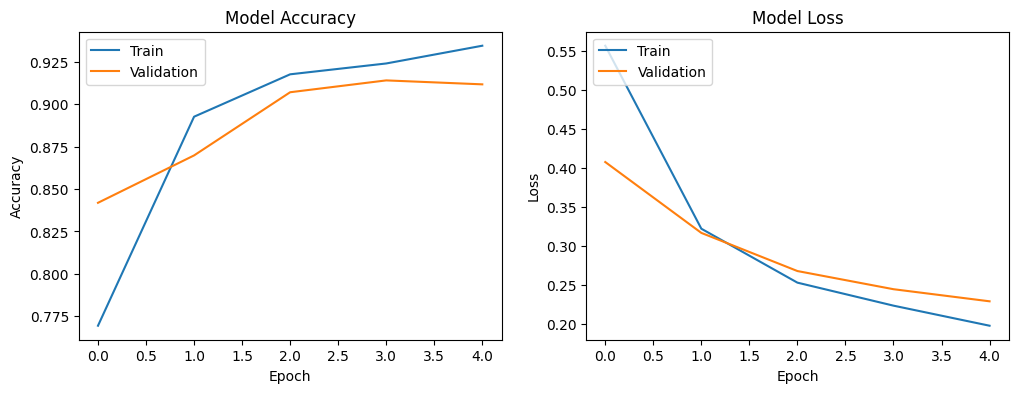


--- Saving the model ---
Model successfully saved to: ../models/potato_disease_model.h5

--- Converting to TensorFlow Lite ---
INFO:tensorflow:Assets written to: C:\Users\nijjo\AppData\Local\Temp\tmpyhvot601\assets


INFO:tensorflow:Assets written to: C:\Users\nijjo\AppData\Local\Temp\tmpyhvot601\assets


Saved artifact at 'C:\Users\nijjo\AppData\Local\Temp\tmpyhvot601'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2228017065680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228017065104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228017065488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228017064720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228017065296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228018905168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228018908624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228018909008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228017064912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2228018908432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

In [10]:
# --- Evaluate the model's performance ---
print("\n--- Evaluating Model Performance ---")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# --- Save the trained model ---
print("\n--- Saving the model ---")
# Define the path to save the model
model_save_path = '../models/potato_disease_model.h5' 
# The .h5 format saves the model architecture, weights, and optimizer state.

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
model.save(model_save_path)

print(f"Model successfully saved to: {model_save_path}")


# --- Convert the model to TensorFlow Lite ---
print("\n--- Converting to TensorFlow Lite ---")
# Define the path for the .tflite model
tflite_model_path = '../models/potato_disease_model.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model successfully converted and saved to: {tflite_model_path}")
print("\n--- Phase 1 is now complete! ---")